#### Import Packages

In [1]:
import json
import pandas as pd
import numpy as np

from numba import jit
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

from utils.system import *
from class_data.data import Data

#### Data

In [2]:
# Load CC openai embeddings
vector_data = Data(folder_path=get_format_data() / 'openai', file_pattern='cc_emb_textemb3small_*')
vector_data = vector_data.concat_files()

Loading Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 766/766 [00:14<00:00, 53.99it/s]


In [3]:
# Load CC articles
article_data = Data(folder_path=get_format_data() / 'token', file_pattern='cc_tokens_*')
article_data = article_data.concat_files()

Loading Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.63it/s]


In [4]:
# Daily Multiple CC Metadata
mdata = Data(folder_path=get_data() / 'cc_multiple', file_pattern='*_mdata.pq')
mdata = mdata.concat_files()

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:02<00:00, 181.48it/s]


In [150]:
mdata.date.min()

Timestamp('2001-01-10 00:00:00')

In [151]:
mdata.date.max()

Timestamp('2020-01-03 00:00:00')

In [5]:
# Create date index
mdata['date'] = pd.to_datetime(mdata['startDate'], format='%d-%b-%y %I:%M%p %Z')
mdata['date'] = mdata['date'].dt.date
mdata['date'] = pd.to_datetime(mdata['date'])
mdata = mdata.set_index('fid')

In [6]:
# Set index for CC embeddings
vector_data.index = article_data['fid']
vector_data = vector_data.join(mdata)
vector_data = vector_data.reset_index().set_index('date').sort_index()
# vector_data = vector_data[['ada_embedding']]
# vector_data = vector_data.loc[~vector_data.ada_embedding.isnull()]

In [7]:
# Set index for CC articles
article_data = article_data.set_index('fid')
article_data = article_data.join(mdata)
article_data = article_data.rename(columns={'Headline': 'headline'})
article_data = article_data.reset_index().set_index('date').sort_index()
# article_data = article_data.loc[~((article_data.index == '2006-10-18') & (article_data.fid == '1391246') & (article_data.content_type == 'Presentation'))]
# article_data = article_data[['headline', 'body_txt']]

#### Check Single Embedding with Parallelized Embedding

In [8]:
def _get_emb(text):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model="text-embedding-3-small").data[0].embedding

In [10]:
test = article_data.copy(deep=True)
test = test.reset_index()

In [11]:
test.loc[test.fid == '1391246']

,date,fid,content_type,body_txt,n_tokens,headline,eventTitle,city,companyName,companyTicker,startDate
126147,2006-10-18,1391246,Presentation,"Good day, ladies and gentlemen. Thank you for ...",4811,Edited Transcript of CIT earnings conference c...,Q3 2006 CIT Group Earnings Conference Call,NEW YORK,CIT Group Inc,CIT,18-Oct-06 3:00pm GMT
126148,2006-10-18,1391246,QA,"(OPERATOR INSTRUCTIONS). Ken Posner, Morgan St...",5870,Edited Transcript of CIT earnings conference c...,Q3 2006 CIT Group Earnings Conference Call,NEW YORK,CIT Group Inc,CIT,18-Oct-06 3:00pm GMT


In [10]:
api_key = json.load(open(get_config() / 'api.json'))['openai_api_key']
client = OpenAI(api_key=api_key)

In [22]:
emb = _get_emb(article_data.body_txt.iloc[126148])

In [24]:
cosine_similarity(np.array(emb).reshape(1, -1), vector_data.iloc[126148]['ada_embedding'].reshape(1, -1) )

array([[1.]])

#### Check AAPL

In [139]:
query = 'Good afternoon. My name is Simona Jankowski, hardware and comm tech analyst at Goldman, and it\'s my distinct pleasure to welcome here Luca Maestri, the CFO of Apple. Thanks for joining us today. Thank you. Before we start our Q&amp;A, I\'ll turn it over to you for the Safe Harbor. Yes, some of my remarks today may include forward-looking statements. Actual results or trends could differ materially. For more information, please see the risk factors discussed in Apple\'s most recent Form 10-K and Form 10-Q that are filed with the SEC. So, Luca, where I wanted to start today is this year is the most momentous in Apple\'s history, in that it marks the 10-year anniversary of the iPhone. Yet it comes after your first-ever decline for that business. So I just wanted to get your thoughts. As you look out to the next 10 years, do you still view the iPhone as a growth business? Well, that\'s obviously a great question. I want to point out, first of all, that actually, here in the December quarter, we went back to growth with iPhone. It was actually very good for us to see.\n We definitely continue to believe that there\'s a lot of room for growth with our iPhone business. It starts with the fact that when we look at the smartphone as a product, as a consumer product, we really believe it\'s become more relevant to people\'s lives than it was 10 years ago, 5 years ago, or even 2 years ago. When you look at how much people rely on their iPhones in every aspect of life, from payments, in the car, in the home, and so I think that\'s a great foundation. The fact that the product is extremely relevant to people\'s lives is very important.\n We also believe that there is a lot of innovation left in the iPhone when we look at the key foundational technologies that go into the product. When you look at processors, you look at sensors, displays, batteries, cameras, we\'ve made a lot of progress here in the last few years on those dimensions, and we think that there is a lot that is left. So we think innovation can continue to help us grow the business.\n When we look at the markets around the world, there\'s a lot of growth that is available to us in emerging markets, starting from China to India, many places around the world where the demographics are such that we can expect a rise in the middle class. We can expect that LTE adoption and smartphone penetration will increase over time. And our market share to start with is extremely low. In a lot of these emerging markets, our market share is low single digits, so we can only grow in a lot of these markets.\n When we look at our customer metrics, they continue to be extremely strong. We look at loyalty rates; we look at customer satisfaction. We look at engagement on our platform, which is extremely high, and that is very good in itself for the future of the iPhone business, and for the fact that we also have a services business that is very much related to the install base of iPhones, which continues to grow very well. And so the sum of all these things, I think, we really believe bode well for the future. And I think if I were to unpack that answer, and that was very helpful, if I was to unpack it a little bit, clearly, you\'re looking for share gains into emerging markets, where your penetration is quite low. When you talked about innovation, should we interpret that as suggesting that at some point the replacement cycle could accelerate again for the iPhone? Well, I think we play a huge role in that. Clearly, if we can come up with products that are very innovative, that inspire people, we obviously know that we can drive upgrade cycles. We\'ve seen it with iPhone 6. The level of upgrade rates that we had with that cycle was very high, and it was driven by the fact that there was a lot of pent-up demand for large-screen iPhones. And if we\'re able to put that level of innovation into future generations of iPhones, definitely, we have a very important -- we have a responsibility in that respect. The iPhone has been a real success story in China, yet last year, we had a few quarters when your business in China was down on the order of 20% to 30%. And obviously, that improved quite a bit in the December quarter. Can you talk a little bit about why you think your sales in China were challenged last year? Was it as simple as comps, or was there anything else going on? And since some of your services are still banned in China, like books and movies, what can Apple do to rejuvenate its iPhone franchise in that region? Well, I think it\'s important -- in this specific case, I think it\'s really important to step back for a second and look at the success that we\'ve had in China over the years. In FY16, we had a $48 billion business in China. It was $3 billion just in FY10, so we\'ve gone from $3 billion to $48 billion in a very, very short period of time.\n And if you take out for a second this very strong cycle that we had in FY16, just moving from FY14 to FY16, in the space of 2 years, our growth in China was 50%. So we\'ve had an incredible level of success in China, and we think the success has been driven by a number of factors -- some macro factors, the fact that clearly, there has been a lot of economic development in the country, to the fact that LTE penetration has improved a lot. But also, I think very, very importantly, we\'ve been able to create in China the same type of ecosystem that we have here in the United States, so that type of customer experience that a Chinese consumer can have around an iPhone is similar, very similar, to what we\'ve got here. We now have Apple Music, Apple Pay, of course, the App Store in China. And that helps us tremendously.\n The services business in China is doing extremely well. We doubled the size of the services business in FY16, and we grew it very, very strongly also during the December quarter. So we see that part of the business continuing to do very well.\n There are a couple of macro issues in China, aside from the fact that the currency has weakened about 6% against the US dollar. And obviously, the Hong Kong market is affected by the fact that the currency in Hong Kong is tied back to the US dollar. So as a trading destination, Hong Kong has become less attractive than it used to be in the past.\n So when you normalize for those things and when you really take a longer-term view of the market and you think about the opportunities still for the middle class to rise in China, we\'re very excited. We continue to make a lot of investments. We continue to open retail stores in China. We opened a lot of new points of sale, and as I said, we continue to expand our services business. One thing I did want to clarify about China is Tim\'s comment on the last earnings call that your decline in China in the current March quarter will be comparable to what you saw in the December quarter, which was 12%. And I think he was suggesting that the comps don\'t get that much easier until the June quarter. But when I look back, last year in March, I think, China was down about 26%. So it would seem to me that comps are already quite easy in the current quarter. I think Tim\'s point was around the fact that the declines a year ago in the third and the fourth quarters were larger than what we\'ve seen in the March quarter. There\'s a couple of things that make the compares a bit more difficult than they would look on the surface.\n The first one is, as I said earlier, is the currency. So the currency on a year-over-year basis is 6% weaker, and so that has just an impact on the actual reported results. That, the fact that the currency\'s weaker, also means that the Hong Kong business continues to be at a depressed level, even more than a year ago. And then there\'s a technical issue around Chinese New Year. Chinese New Year this year was sooner than it was a year ago. And typically, what happens with sales trends, they tend to be up until the Chinese New Year, and then they come down. And so we got a couple of weeks of very difficult compares in China this year. That makes sense. Thank you. I want shift gears now to your services business, which has been incredibly successful. It\'s been accelerating for a few quarters in a row now. I think last quarter on an organic basis, it was up something like 30%, and you guys gave a new target for the first time of doubling that business, looking out 4 years. And I\'ll come back to that specific point.\n But where I wanted to start on this topic is we\'re also seeing some interesting shifts in the market. We\'ve seen a big move away from downloads, where you guys were an innovator with iTunes, the streaming video. And then we\'ve seen incredible success for services like Netflix and Amazon Prime. So what do you say to investors who basically look at Apple and say, "Yes, they\'re very successful with apps, but are they really as well positioned in video and music as they could be?" Well, obviously, I think overall, the services business is doing very well, and we\'ve been growing it for several quarters now. It is up 20%, and the reason why we\'ve given out this goal is it\'s our internal goal. And I think it\'s important for us to send a message to the investment community that this is a business that today, on a standalone basis, this year it\'s going to be the size of a Fortune 100 company. Obviously, if we\'re able to double it in 4 years, it\'s going to be even bigger. And we don\'t know exactly how we\'re going to get there, although we see a lot of trends that are very positive for us, and so we will continue to push on all these fronts. And so as I said, the App Store is doing incredibly well. The level of -- the quality and the quantity of content continues to improve all the time.\n You were asking music and videos. Starting with music, I think it\'s important to keep in mind we are by far the largest player in digital music. When you combine our download model with our streaming service, which comes from the Beats acquisition, and it\'s getting a lot of traction, the combination of these two businesses, we\'re clearly the number one in music. We\'ve got a long association with music. It\'s one of the most important use cases for customers on our devices. And so we really want to provide the best possible offering on the music side, and we think we\'re actually doing that, because when we look at customer satisfaction surveys, we come out on top. And we continue to improve the service from a user interface standpoint, and also into some content.\n One thing that we\'ve learned, having been associated with music for a long period of time, is that exclusives and exclusive content make a difference. They make a difference in terms of the number of transactions that happen in our stores, in terms of the conversion rates, in terms of the free trials that happen on the streaming service. So we do understand the value of exclusive content.\n And therefore when you think about video, which again, already today for us is a large business because we are a very large distributor of video content already today, obviously, it\'s something that we\'re looking into. And we\'ve made a couple of announcements recently about some of the shows that we\'re starting to experiment with that initially are going to be available on Apple Music. And we think we\'ll take it from there, and we\'re going to learn a lot out of these initial examples. I think Tim said on one of the recent earnings calls that Apple has an interest in the creation and ownership of content. And I think we\'ve seen, as you mentioned, some of the shows that you guys have been working on, like the trailer for Planet of the Apps that\'s out today looks real interesting. But what would it take for Apple to move past dipping your toe in the water with a couple of shows and making a more significant commitment to content, especially given the obvious benefits to the ecosystem, the fact that you\'ve got significant cash that, hopefully, you\'ll get access to if we have something like repatriation? So what would be evidence of success or benchmarks that you would be looking at? As I said, we know that original content is important. We\'ve seen it on the music front. And so I think for us, it\'s a matter of experimenting a bit to see how we do with these initial shows, and we\'ll take it from there, because really, I don\'t have anything to announce today, but obviously, it\'s something that we look at. Sure, okay. And just to stay on that topic for a second, so there\'s been a lot of interest this year in the policy changes that are underway with the new Administration. One of the big ones that looks reasonably likely to pass is repatriation, and Apple is certainly on the top of the list in terms of overseas cash, which is over $200 billion. Can you share with us anything, to the extent you can, on the priorities for you for that cash? Yes. We have been pretty vocal for years now that the US Tax Code needs to be reformed. The situation that we\'ve got right now is not good. Corporate tax of 35% is the highest tax in the world. It\'s punitive for US companies. It creates international tensions across jurisdictions because of this deferral system that is in place in the United States. And so we\'ve been saying for a number of years that we really need reform, corporate tax reform. And we think that there is broad agreement, not around the specifics, but around the concept that tax reform should happen. And hopefully, there is a good chance that something is going to happen this year. And obviously, one important element, as you said, is the repatriation of accumulated earnings. And of course, we have a lot of that overseas, because now two-thirds of the Company, of the revenue, is overseas.\n Obviously, we would be looking to bring the cash back, and that would give us additional flexibility around our capital return activities. We\'ve got this, I would say, unprecedented capital return program. We\'ve already returned $200 billion since we started it 4.5 years ago. And until reform happens, we will continue to do that. We will provide an update in the spring on the program. But if and when reform happens, it gives us more flexibility, and we could do more, and more quickly. That makes a lot of sense on the capital return side. I wanted to touch on the optionality around M&amp;A as well. One of Tim\'s comments recently was that Apple is open to acquisitions of any size that are of strategic value. And I think a few of us interpreted that as being a little bit of a different nuance than the historical focus Apple has had, which has been more on smaller technology buys or tuck-ins. So was that a fair interpretation? I would say, Simona, that our approach has not changed. We have, and what Tim said during the call, is something that has been true for us forever. We\'ve always looked at any size of acquisitions in to be honest, the size of the check is not what matters to us. We\'re in a very fortunate position. We can afford them.\n The issue, as Tim said, is the strategic fit, and the issue is, do we believe that we can create value for our investors as we make acquisitions? In the past, it\'s been the case that the vast majority of our acquisitions have been small companies. We buy between 15 and 20 companies every year, and we\'ve done it pretty regularly. And typically, it\'s around these great technologies, great intellectual property that we\'re very excited about that either allow us to fill a gap for the portfolio or allow us to accelerate our product roadmaps. Siri was an acquisition. Attach ID was an acquisition. It\'s beautiful to bring this great idea into Apple and then being able to scale it very quickly.\n But, for example, Beats, which was a larger acquisition -- certainly for us, because we ended up paying $3 billion -- fit these two very well. A great strategic fit, because we knew that we had a hole in our portfolio around streaming music, and Beats had a great service that really fit what we wanted to do. And on the headphone side, we could see that we could generate a lot of value because the components that they use for those products are very similar to the components that we purchase, and because Beats was very strong in the United States, and we were able to take those products outside the United States because of our distribution capabilities.\n If we\'re able to find companies that fit the strategic element and the value element, it\'s not the size that creates an issue for us. That\'s clear. Thank you. One of the other policy changes under consideration is a move to a destination-based tax regime, under which US revenues would be taxed. However, the imported cost of goods would not be deductible. And given that most of your products are manufactured overseas, technically, that would be counted as an import. So just curious, to the extent you\'ve looked into it so far, how would this kind of a change affect your cash flow and P&amp;L? Well, we obviously are looking at anything that is happening in the tax arena very closely because it\'s obviously a very important matter for the Company. It\'s very difficult to speculate before any legislation is enacted. If we step back for a second and we look at the proposals that are out there right now around tax reform, I would maybe categorize it into three major buckets.\n The issue around repatriation of the foreign cash. And I think, in that respect, there is a lot of consensus that that cash should be brought back at a significantly lower rate than today. So I think there, I don\'t think there\'s any disagreement.\n And when we look prospectively into the future, there\'s two elements. There\'s the foreign earnings and the domestic earnings. So on the foreign earnings, also in that respect, when we look at the proposals that are out there, there is a general agreement that that rate should come down versus the 35% that is the current rate. We think it\'s important that that rate be applied to foreign earnings, because I think -- we believe that US companies will tend to rely on international markets more and more over time, just because of the global nature of business.\n And then the third element, where there is still not a very clear commonality of intent, is how domestic earnings should be taxed and then this issue around border tax. Without getting into the specifics of it, because again, we haven\'t seen written legislation around it, it is very hard for us to imagine that a border tax would be good for the US economy, because it is a tax that would end up burdening the end consumer and because it presupposes as an idea the fact that the dollar would have to appreciate very significantly versus where it is today, which is already too strong. And so when you think about the competitiveness of the US economy, when you think of jobs creation in this country, when you think about investments in this country, it doesn\'t feel that that would be a positive outcome. Yes, and recognizing that it\'s not necessarily a positive and it may not even be where we end up -- I think The Economist just assigned about a 20% probability of the border tax adjustment system coming into play -- but could you help us think about the feasibility of Apple\'s manufacturing and supply chain moving to the US if such a change were to happen? Well, I think again, it\'s very, very difficult to speculate at this point. One of the points that we are making in Washington is the fact that we have been a very large contributor to the US economy during the last decade. We made billions of investments in the United States. In the last 10 years, we created about 2 million jobs in this country in the developer community, in our retail stores, in our call centers, and through the supplier chain. And so I think it\'s important to keep that in mind. And those are investments that we will continue to make into the future. I think you know very well, because of your job, that essentially the supply chain for the tech industry is not in the US today, right? Yes. Maybe shifting gears to gross margins, which is another topic that is much discussed in the investor community, commodity prices have been stubbornly high in the last year, whether you look at memory or LCD panels. And you guys keep adding a lot of new features and innovations, and we\'re looking forward to, hopefully, more with the next iPhone. And as you mentioned earlier, FX is not cooperating. So when you consider all of these items, which seem to be adding pressure, how should we think about gross margins for you on a go-forward basis, and the different offsets that you have at your disposal? Yes, of course, we fully understand that gross margin is a very important metric for investors. And I think if you look back at the last 5 years, our gross margins have been in this 38% and 40% range, in this range, in spite of the foreign exchange moving up and down. We have a good track record at managing all the different levers in the business, recognizing the fact that because of what you said, because essentially the success of the Company is around innovation, every time we launch a new product -- every single time we launch a new product -- the cost structure of that new product is higher than the cost structure of the product that it replaces. It is because we\'re adding new technologies, new features, and therefore, we have that pressure.\n We have been able to offset that pressure in a number of ways, starting with our ability to take those structures down during the course of a certain life cycle of the product, and we\'ve done a very good job on that. We use pricing to try and offset some of the margin pressures, the cost pressures. And, of course, the fact that the services business is growing well, it helps us mitigate some of the pressures. I said in the past that our services business in its totality has a margin profile that is accretive to Company margins. So if we\'re able to continue to grow that business well, that will provide us with some offset.\n At the end of the day, though, as much as we understand the importance of gross margin percentages, the way we try to price our products and to bring the products to market is to ensure that we maximize gross margin dollars, because I think it would be very easy to have very high gross margin percentages, but then we wouldn\'t be selling very much. And so at the end of the day, also for investors, it\'s important to think that we really try to optimize gross margin dollars. One of the levers that I think you guys have also had, maybe not at your disposal, because it\'s not necessarily in your control, but it has happened nonetheless, is this mix shift that we\'ve observed with the iPhone 7 to the larger form factor, which I think has been helpful to gross margins. Do you see that trend continuing on a go-forward basis in terms of the mix shift to the higher, to the larger phone? We were expecting that that mix shift would happen. We\'ve been surprised during the December quarter by the extent of it. Clearly, demand for iPhone 7-Plus was stronger than we were anticipating. And we attribute it to a couple of factors. I think the main one is the fact that this was the first cycle when we introduced into the 7-Plus version a unique feature that is not available on the 7, which is the dual-camera system. And clearly, even though we priced for it, clearly, there was a lot of customer interest, and therefore the mix has moved more towards the 7-Plus.\n In general, it is quite possible that customers are getting more and more used to larger screens, and that is a trend that might continue in the future. It\'s very true, certainly, in certain geographic areas like Asia, without a doubt. I want to ask you also about R&amp;D. So we\'ve seen your R&amp;D intensity more than double in the last 4 years. But at the same time, top line growth has actually slowed down in that period of time. So maybe just help us understand how you think about R&amp;D, and is the reason it\'s expanding so much because you need that much more R&amp;D just to support what is now an ever-increasing base of devices and customers? Or is it because you\'re working on some amazing new features that, hopefully, we\'ll see in the not-too-distant future? It\'s probably all of the above. I think it\'s important to think about R&amp;D spend both in absolute terms and in relative terms. If I just talk about, first, about the absolute level of R&amp;D spend that we have, it\'s clearly higher than it was in the past. I would say there\'s four primary reasons for that.\n The first one is the fact that our product portfolio today is much larger than it used to be. We now develop three iPhones; we used to develop one. We develop multiple iPads; we used to develop one. We now have the watch. We\'ve got AirPods; we have Beats. So the product portfolio is larger, and obviously, we need more R&amp;D to develop those programs.\n The second element is that the services business has grown a lot, and to grow the business, we need to make engineering investments in services like iCloud, like Siri, like Maps. And so clearly, the R&amp;D spend that we have on services is significantly higher than we used to have.\n The third reason, I think, is a very strategic one and a very important one that allows us to keep our differentiation from the rest of the industry. And it\'s the fact that today, we do much more in-house development of some fundamental technologies than we used to do a few years ago, when we were leaving more of that to the supplier base. Think of the work that we do around processors or sensors -- much more work that we\'re doing today in-house than we used to. It\'s very important for us because we can push the envelope on innovation, we have better control over timing, over cost, over quality. And so we look at that as a great strategic investment for us.\n And then finally, the point that you were making around the fact that yes, we\'re also working on things that do not generate revenue today, and those expenses are meaningful. In the total scheme of things, they\'re not very large, but obviously, they add up over time, and hopefully, those are good bets that we\'re making for the future of the Company.\n In relative terms, you can look at us compared to the rest of the tech industry, and I think it\'s almost difficult to compare because our R&amp;D efficiency is much better than the rest of the tech industry guys. It\'s difficult to compare with other tech companies. When we look at Apple today versus the past and you look at that percentage growing, I think that\'s where some of the investor concern comes from. But I will tell you that it\'s actually pretty intuitive that that percentage goes up.\n If you take the extreme where we are only developing the iPhone -- and I looked at the engineering efficiency of our iPhone programs -- that efficiency has not changed over the years, and it\'s obviously, the percentage is very low because the smartphone market is so large. We are now developing a lot of products that participating markets are much smaller than the smartphone market, and therefore, it is pretty intuitive that when we developed the watch, for example, which is very successful in itself. But obviously, because the wearables market, the smart watch market is much smaller, it is obvious that on a percentage basis, it\'s more expensive to develop the watch than to develop the iPhone.\n But the alternative is not a good one. We cannot just work on the iPhone. And as we add other products, it is normal and natural that that engineering percentage of revenue moves up a bit. Got it. So just as we think about modeling the business, OpEx as a percent of sales was about 11%, or a little over 11% last year. Historically, it was closer to 10%, but we shouldn\'t necessarily think of that 10% being an anchor or something that you\'re trying to get back to. No, we said, critically, our target\'s around OpEx in absolute terms. So every line item of our OpEx is -- you know, we have our own planning process and we set targets for that. But in absolute terms, because then the relative success of our products in the marketplace will dictate if the percentage is 10%, 11%, 9%, 12%, whatever that is.\n I think what you\'ve seen during the last several quarters is that clearly, we try to put all the investments that we need to make into R&amp;D, and the R&amp;D number has been going up quite a bit. But on the SG&amp;A side of the business, we try to squeeze as much efficiency as possible because of our scale. And actually, we\'ve seen in FY16 our SG&amp;A was essentially flat, if not slightly down. And I think you\'ll continue to see those dynamics. Investments, for the reasons that I talked about, in R&amp;D, and try to manage SG&amp;A pretty tightly. You mentioned the Apple Watch, and I did want to ask you a question on that. It had a great holiday season. Is that product now closer to fulfilling its potential, or do you feel like you\'re still scratching the surface? Yes, we think it\'s still very early stages. We feel very good. It was the best quarter we\'ve ever had. Units revenue across the board, it was very interesting to see the mix. We could have sold more, to be honest, but we were supply constrained. Now we have a Series 1 and Series 2 in the marketplace, and customers seem to be very, very attracted by the Series 2, which has all the new features and technologies, so it\'s great to see. We continue to expand points of sale. But I think we think it\'s a great platform to innovate on, for example, in spaces like health and research and fitness. And so it\'s early stages, but we feel very, very good about the momentum.\n And in general, when we look at Apple Watch, we look at the AirPods that we just launched recently, and we look at Beats, and we put them all together as the wearables category of the products that we sell, we feel that in all cases a lot of momentum, and it\'s a business that on a standalone basis is already becoming a very significant business. And the last question from me. You\'re moving to your new headquarters this year. What are your hopes and expectations for that space? The new campus, I really think, is going to be like a national landmark. I think there\'s going to be a lot of interest from tourists to come and visit, so we need to figure out exactly how to manage that. But this is really Steve\'s vision for our employees, particularly for the engineering and the creative teams. And his view was having an office space that really fostered collaboration. And the way the work spaces are designed and the layout very much encourages that type of our collaboration, and we think it\'s going to be a great place for our people to innovate for many, many years to come.\n It\'s also very environmentally friendly -- natural ventilation, all natural light, very smart building controls, and very energy efficient, because the electricity will be generated onsite through solar and fuel cell. So I think it\'s going to be -- we\'d be very, very happy to host you very soon. Thank you. And unfortunately, we are delayed a few weeks because of the rain here in California. Just, it\'s so unusual, that now that we\'re doing the landscaping, so it\'s going to take a few more weeks, but we are almost there. Well, good luck with the move, and thank you so much for joining us today. Thank you very much. Thank you.'

In [140]:
query = _get_emb(query)

In [141]:
tic_vec = vector_data.loc[vector_data.companyTicker == 'AAPL']

In [142]:
score = cosine_similarity(np.array(query).reshape(1,-1), np.stack(tic_vec.ada_embedding.values))

In [143]:
score_df = pd.DataFrame(score.reshape([-1,1]), index=tic_vec.index, columns=['score'])

array([[<Axes: title={'center': 'score'}>]], dtype=object)

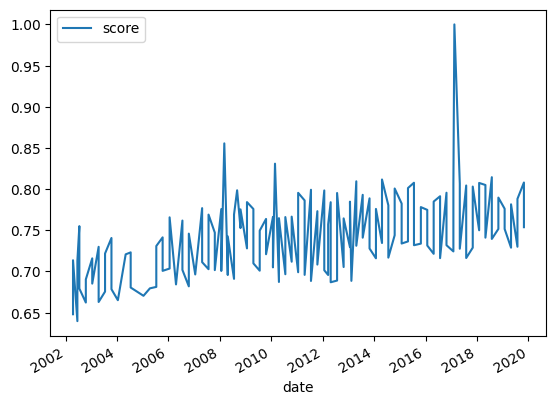

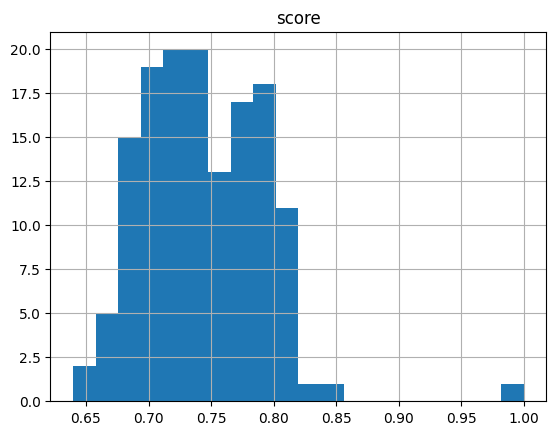

In [145]:
score_df.plot()
score_df.hist(bins=20)

In [146]:
before_2007 = score_df.loc[score_df.index >= '2007-01-01']

In [148]:
before_2007.sort_values('score').tail(10)

,score
date,
2017-05-02,0.806606
2018-02-01,0.807464
2015-07-21,0.807708
2019-10-30,0.808010
2013-04-23,0.809447
2014-04-23,0.811646
2018-07-31,0.814444
2010-02-23,0.830868
2008-03-05,0.855527


In [138]:
article_data.loc[(article_data.index == '2017-02-14') & (article_data.companyTicker == 'AAPL')].iloc[0]['body_txt']

'Good afternoon. My name is Simona Jankowski, hardware and comm tech analyst at Goldman, and it\'s my distinct pleasure to welcome here Luca Maestri, the CFO of Apple. Thanks for joining us today. Thank you. Before we start our Q&amp;A, I\'ll turn it over to you for the Safe Harbor. Yes, some of my remarks today may include forward-looking statements. Actual results or trends could differ materially. For more information, please see the risk factors discussed in Apple\'s most recent Form 10-K and Form 10-Q that are filed with the SEC. So, Luca, where I wanted to start today is this year is the most momentous in Apple\'s history, in that it marks the 10-year anniversary of the iPhone. Yet it comes after your first-ever decline for that business. So I just wanted to get your thoughts. As you look out to the next 10 years, do you still view the iPhone as a growth business? Well, that\'s obviously a great question. I want to point out, first of all, that actually, here in the December quar